# Electric Vehicle Charge Scheduling MDP

### Dependencies

You will need to install POMDPs and POMDPToolbox locally before being able to run this notebook. This can be done by running the following in your local Julia 1.0 REPL: 
    - Pkg.add("POMDPs")
    - Pkg.add("POMDPModelTools")
    - Pkg.add("POMDPSimulators")

In [1]:
using POMDPs, POMDPModelTools, POMDPSimulators, Random, Plots, DiscreteValueIteration

### State Structure
Define state structure / make initial constructor

In [2]:
mutable struct evState
    p::Vector{Bool} # array of whether cars are present
    c::Vector{Int64} # array of charge in each car
    renew::Int64 # renewable energy level
    t::Int64 # time
    done::Bool # are we in a terminal state
end

# initial state constructor
evState(p,c,renew::Int64,t::Int64) = evState(p,c,renew,t,false)

evState

### MDP Structure
Define MDP structure with everything you would need / make initial constructor

In [3]:
struct evMDP <: MDP{evState,Vector{Bool}} 
    n::Int64 # number of cars
    T::Int64 # number of timesteps
    renew_levels::Int64 # number of renewable mixture levels, 0:renew_levels
    charge_levels::Int64 # number of charge levels, 0:charge_levels
    λ::Float64 # terminal reward weighting
end

# we use key worded arguments so we can change any of the values we pass in 
function evMDP(;n::Int64 = 3, # number of cars
                T::Int64 = 6, # number of timesteps
                renew_levels::Int64 = 3, # number of renewable mixture levels, 0:renew_levels
                charge_levels::Int64 = 3, # number of charge levels, 0:charge_levels
                λ::Float64 = 10.0) #terminal reward weighting
    return evMDP(n, T, renew_levels, charge_levels, λ)
end


evMDP

### States
Define all possible states

In [4]:
# convert number to an array of numbers using requested base system, array length
function num2array(number,base,array_length)
    base==2 ? finalarray = zeros(Bool, array_length) : finalarray = zeros(Int64, array_length)
    idx=1
    while number > 0
        finalarray[idx] = rem(number,base)
        number = div(number,base)
        idx+=1
    end
    return finalarray
end

function POMDPs.states(mdp::evMDP)
    s = [] # initialize an array of GridWorldStates
    
    # add every possible state. This includes every possible combination of present/charge array
    
    for iP = 0:(2^mdp.n-1)
        present = num2array(iP,2,mdp.n)
        
        for iC = 0:((mdp.charge_levels+1)^mdp.n-1)
            charge = num2array(iC,(mdp.charge_levels+1),mdp.n)
            
            for rl=0:mdp.renew_levels, t=1:mdp.T
            
                # if in final time, make sure the done flag is set on
                t==mdp.T ? push!(s,evState(present, charge, rl, t, true)) : push!(s,evState(present, charge, rl, t)) 
            end
        end
    end
    return s
end


In [5]:
POMDPs.initialstate(mdp::evMDP, rng::AbstractRNG) = evState(zeros(Bool,mdp.n),zeros(Int64,mdp.n), mdp.renew_levels, 1)
POMDPs.initialstate(mdp::evMDP) = POMDPs.initialstate(mdp,MersenneTwister(1))

### Actions
Define all possible action vectors

In [6]:
function POMDPs.actions(mdp::evMDP)
    # initialize empty action space a
    a = []    
    # populate with all combinations of actions, ex [true, false, true, true]
    for iA=0:(2^mdp.n-1)
        push!(a,num2array(iA,2,mdp.n))
    end
    return a
end
    

### Reward Function
Define the reward function

In [7]:
function POMDPs.reward(mdp::evMDP, state::evState, action::Vector{Bool}, statep::evState)
    r = mdp.λ*state.renew 
    if statep.done
        max_c = mdp.charge_levels
        for i in 1:length(state.p)
            if state.p[i] == true
                r -= exp((max_c-state.c[i])/max_c)
            end
        end
    end
    return r
end

### Transition Function
Define the next-state transition probabilities (this is the hard one)

In [8]:

# chance of a car appearing in any slot at time t given total timescale T
carAppearProb(t,T) = 1/(1+exp(-20(t-2)/T))

# function takes a state to generate different charge probabilities for, the previous presence array, the mdp, 
# and the probability of transitioning to 
function carAppearStates(baseState,prevP,mdp,probability)
    
    newCarIdxs = findall(baseState.p .!= prevP)
    
    # distribute probabilities uniformly over possible charge states
    probs = zeros(Int64,mdp.charge_levels^length(newCarIdxs)) .+ probability/(mdp.charge_levels^length(newCarIdxs))
    
    chargeCombs = [baseState.c[:]]
    for ind in newCarIdxs
        chargeCombsPrev = chargeCombs
        
        chargeCombs = []
        for charge in chargeCombsPrev, level in 0:(mdp.charge_levels-1)
            addition = charge[:]
            addition[ind] = level
            push!(chargeCombs,addition)
        end
    end
    
    state_vec = evState[]
    for charge in chargeCombs
        push!(state_vec,evState(baseState.p, charge, baseState.renew, baseState.t, baseState.done))
    end
    return state_vec, probs
end
    
    

carAppearStates (generic function with 1 method)

In [9]:
prevP = [true, false, true, false]

newP = [true, true, true, true]
newC = [3, 4, 4, 4]
baseState = evState(newP,newC,0,1,false)
test_mdp = evMDP(4,4,4,4,0.1)

states,probs = carAppearStates(baseState,prevP,test_mdp,1.0)
println(states)
println(probs)

evState[evState(Bool[true, true, true, true], [3, 0, 4, 0], 0, 1, false), evState(Bool[true, true, true, true], [3, 0, 4, 1], 0, 1, false), evState(Bool[true, true, true, true], [3, 0, 4, 2], 0, 1, false), evState(Bool[true, true, true, true], [3, 0, 4, 3], 0, 1, false), evState(Bool[true, true, true, true], [3, 1, 4, 0], 0, 1, false), evState(Bool[true, true, true, true], [3, 1, 4, 1], 0, 1, false), evState(Bool[true, true, true, true], [3, 1, 4, 2], 0, 1, false), evState(Bool[true, true, true, true], [3, 1, 4, 3], 0, 1, false), evState(Bool[true, true, true, true], [3, 2, 4, 0], 0, 1, false), evState(Bool[true, true, true, true], [3, 2, 4, 1], 0, 1, false), evState(Bool[true, true, true, true], [3, 2, 4, 2], 0, 1, false), evState(Bool[true, true, true, true], [3, 2, 4, 3], 0, 1, false), evState(Bool[true, true, true, true], [3, 3, 4, 0], 0, 1, false), evState(Bool[true, true, true, true], [3, 3, 4, 1], 0, 1, false), evState(Bool[true, true, true, true], [3, 3, 4, 2], 0, 1, false), ev

In [10]:
min.(4,[1, 0, 5, 4] + [true, false, false, true].*[false, true, true, true])

4-element Array{Int64,1}:
 1
 0
 4
 4

In [11]:
function getNextPs(p,car_prob)
    wherenocars = findall(iszero,p)
    p_next = [p]
    for ind in wherenocars
        p_next_prev = p_next
        p_next = []
        for p in p_next_prev
            push!(p_next,p)
            state_new = p[:]
            state_new[ind] = true
            push!(p_next,state_new)        
        end
    end
    
    
    # calculate probability
    num_initial_spaces = length(wherenocars)
    num_new_cars = []
    for p_check in p_next
        n_new_cars = count(p_check .!= p)
        push!(num_new_cars,n_new_cars)
    end
    probs = [(car_prob^n)*(1-car_prob)^(num_initial_spaces-n) for n in num_new_cars]
    
    return p_next, probs
    
end

getNextPs (generic function with 1 method)

In [12]:
p, pr = getNextPs([true, false, false],.75)
println(p)
println(pr)

Any[Bool[true, false, false], Bool[true, false, true], Bool[true, true, false], Bool[true, true, true]]
[0.0625, 0.1875, 0.1875, 0.5625]


In [13]:
calc_renew_delt(t) = 0

function POMDPs.transition(mdp::evMDP, state::evState, action::Vector{Bool})
    
    # deterministic transitions
    
    # time and teriminality
    t_next = state.t + 1
    t_next == mdp.T ? done_bool = true : done_bool = false
    
    # energy level
    delta_charge = 0.5/4 # Amount of energy lost per charge per car as a fraction of total charge level
    renew_next = round.(Int8,state.renew + (calc_renew_delt(t) - length(findall(action))*delta_charge)*mdp.renew_levels)
    
    # charge in each car
    # c_next = round.(Int8, state.c + action*delta_charge*mdp.renew_levels)
    c_next = min.(mdp.charge_levels, state.c + action.*state.p) # increment by one if charge action taken when car present, and cap at max charge
    
    # probabilistic transitions
    
    # car presence
    appear_prob = carAppearProb(t_next,mdp.T)
    p_next, probs = getNextPs(state.p[:],appear_prob)
    
    # build next state array
    next_states = [evState(p_new,c_next,renew_next,t_next,done_bool) for p_new in p_next]
    # updated_states, updated_probs = [carAppearStates(baseState,state.p,mdp,probability) for baseState,probability in zip(next_states,probs)] ]
    new_states = []
    new_probs = Float64[]
    
    for i in 1:length(next_states)
        updated_state, updated_prob = carAppearStates(next_states[i],state.p,mdp,probs[i])
        push!(new_states,updated_state...)
        push!(new_probs,updated_prob...)
    end
    
    # new_states, new_probs = [s[:],p[:] for s,p in zip(updated_states,updated_probs)]
    # add section to incorporate different possible start charges

    return SparseCat(new_states,new_probs)
end

In [14]:
round.(Int8,3-1*.25/4*4)

3

In [15]:
j = [true, true, false, false]
print(findall(j))

[1, 2]

In [16]:
test_mdp = evMDP(4,4,4,4,0.1)


P = [true, false, true, false]
action = [true, true, true, true]
C = [3, 0, 4, 0]
baseState = evState(P,C,0,1,false)

POMDPs.transition(test_mdp,baseState,action)


SparseCat{Array{Any,1},Array{Float64,1}}(Any[evState(Bool[true, false, true, false], [4, 0, 4, 0], -2, 2, false), evState(Bool[true, false, true, true], [4, 0, 4, 0], -2, 2, false), evState(Bool[true, false, true, true], [4, 0, 4, 1], -2, 2, false), evState(Bool[true, false, true, true], [4, 0, 4, 2], -2, 2, false), evState(Bool[true, false, true, true], [4, 0, 4, 3], -2, 2, false), evState(Bool[true, true, true, false], [4, 0, 4, 0], -2, 2, false), evState(Bool[true, true, true, false], [4, 1, 4, 0], -2, 2, false), evState(Bool[true, true, true, false], [4, 2, 4, 0], -2, 2, false), evState(Bool[true, true, true, false], [4, 3, 4, 0], -2, 2, false), evState(Bool[true, true, true, true], [4, 0, 4, 0], -2, 2, false)  …  evState(Bool[true, true, true, true], [4, 1, 4, 2], -2, 2, false), evState(Bool[true, true, true, true], [4, 1, 4, 3], -2, 2, false), evState(Bool[true, true, true, true], [4, 2, 4, 0], -2, 2, false), evState(Bool[true, true, true, true], [4, 2, 4, 1], -2, 2, false), evSt

### Miscellaneous Functions
Define other functions that POMDPs.jl needs

In [17]:
POMDPs.n_states(mdp::evMDP) = 2^mdp.n*(mdp.charge_levels+1)^mdp.n*(mdp.renew_levels+1)*mdp.T
POMDPs.n_actions(mdp::evMDP) = 2^mdp.n
POMDPs.discount(mdp::evMDP) = 1.
POMDPs.isterminal(mdp::evMDP, s::evState) = s.done

In [18]:
# define state and action indexing
function indVal(base, a)
    ind = 1
    for i in 1:length(a)
        ind += a[i]*base^(i-1)
    end
    return ind
end    

function POMDPs.stateindex(mdp::evMDP, state::evState)
    indP = indVal(2,state.p)
    indC = indVal(1+mdp.charge_levels,state.c)
    indR = state.renew + 1
    indT = state.t
    maxP = 2^(mdp.n)
    maxC = (mdp.charge_levels + 1)^(mdp.n)
    maxR = mdp.renew_levels + 1
    maxT = mdp.T
    sInd = indP + (maxP*(indC-1)) + (maxC*maxP*(indR-1)) + (maxR*maxC*maxP*(indT-1))
    return sInd
end

function POMDPs.actionindex(mdp::evMDP, act::Vector{Bool})
    return indVal(2,act)
end

In [19]:
mdp1 = evMDP()
state1 = evState([false,false,false],[0,0,0],0,0,true)
# (;n::Int64 = 3, # number of cars
#                T::Int64 = 6, # number of timesteps
#                renew_levels::Int64 = 3, # number of renewable mixture levels, 0:renew_levels
#                charge_levels::Int64 = 3, # number of charge levels, 0:charge_levels
#                 λ::Float64 = 100.0) #terminal reward weighting
println(POMDPs.stateindex(mdp1,state1))


-2047


In [20]:
mdp = evMDP()
st = POMDPs.states(mdp)
println(length(st))
for i in 1:length(st)
    idx = stateindex(mdp,st[i])
    if idx < 1
        println(idx)
        println(st[i])
     end
end

j = ordered_states(mdp)
for (istate,s) in enumerate(j) 
    # println(istate)
end

12288


### Implement Solvers / Simulators

In [21]:
# initialize the problem
mdp = evMDP(n=4,renew_levels=4)
#=Defaults
n::Int64 = 3, # number of cars
T::Int64 = 6, # number of timesteps         
renew_levels::Int64 = 3, # number of renewable mixture levels, 0:renew_levels
charge_levels::Int64 = 3, # number of charge levels, 0:charge_levels
λ::Float64 = 10.0)
=#
@requirements_info ValueIterationSolver() mdp


solver = ValueIterationSolver(max_iterations=100, belres=1e-6, verbose=true) # initializes the Solver type
policy = solve(solver, mdp) # runs value iterations

# initialize the policy by passing in your problem
# policy = ValueIterationPolicy(mdp) 

# solve for an optimal policy
# if verbose=false, the text output will be supressed (false by default)
# solve(solver, mdp, policy, verbose=true);

INFO: POMDPs.jl requirements for solve(::ValueIterationSolver, ::Union{MDP,POMDP}) and dependencies. ([✔] = implemented correctly; [X] = missing)

For solve(::ValueIterationSolver, ::Union{MDP,POMDP}):
  [✔] discount(::evMDP)
  [✔] n_states(::evMDP)
  [✔] n_actions(::evMDP)
  [✔] transition(::evMDP, ::evState, ::Array)
  [✔] reward(::evMDP, ::evState, ::Array, ::evState)
  [✔] stateindex(::evMDP, ::evState)
  [✔] actionindex(::evMDP, ::Array)
  [✔] actions(::evMDP, ::evState)
  [✔] support(::SparseCat)
  [✔] pdf(::SparseCat, ::evState)
For ordered_states(::Union{MDP,POMDP}) (in solve(::ValueIterationSolver, ::Union{MDP,POMDP})):
  [✔] states(::evMDP)
For ordered_actions(::Union{MDP,POMDP}) (in solve(::ValueIterationSolver, ::Union{MDP,POMDP})):
  [✔] actions(::evMDP)
[Iteration 1   ] residual:         40 | iteration runtime: 123080.454 ms, (       123 s total)
[Iteration 2   ] residual:         40 | iteration runtime: 111511.787 ms, (       235 s total)
[Iteration 3   ] residual:      

### Simulations

In [54]:
solve_evMDP(mdp) = solve(ValueIterationSolver(max_iterations=100, belres=1e-6, verbose=true), mdp)

function simulate_evMDP(mdp,policy;seed=1)
    history = simulate(HistoryRecorder(max_steps=100,rng = MersenneTwister(seed)), mdp, policy, POMDPs.initialstate(mdp))

    counter = 0
    ev = zeros(Int8,mdp.T-1,mdp.n)
    # look at what happened
    for (s, a, r) in eachstep(history, "(s, a, r)")
        counter +=1
        ev[counter,:] = s.c + s.p .- 1
        println("State was $s,")
        println("Reward was $r,")
        println("action $a was taken,")
    end
    return ev
end

simulate_evMDP (generic function with 1 method)

State was evState(Bool[false, false, false, false], [0, 0, 0, 0], 4, 1, false),
Reward was 40.0,
action Bool[false, false, false, false] was taken,
State was evState(Bool[true, false, false, false], [1, 0, 0, 0], 4, 2, false),
Reward was 40.0,
action Bool[true, true, false, false] was taken,
State was evState(Bool[true, true, true, true], [2, 2, 0, 2], 3, 3, false),
Reward was 30.0,
action Bool[true, true, true, true] was taken,
State was evState(Bool[true, true, true, true], [3, 3, 1, 3], 1, 4, false),
Reward was 10.0,
action Bool[true, true, true, true] was taken,
State was evState(Bool[true, true, true, true], [3, 3, 2, 3], -1, 5, false),
Reward was -14.395612425086089,
action Bool[false, false, true, false] was taken,


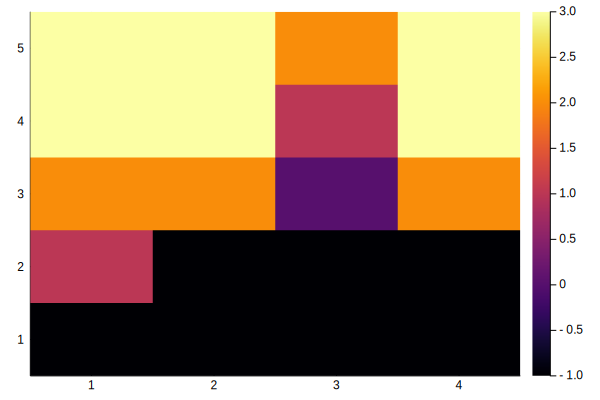

In [52]:
ev = simulate_evMDP(mdp,policy,seed=5)
heatmap(ev)

## Example initializing, solving, simulating, and plotting

In [63]:
test_mdp = evMDP(λ=20.,T=8)
policy = solve_evMDP(test_mdp)

[Iteration 1   ] residual:         60 | iteration runtime:   4750.539 ms, (      4.75 s total)
[Iteration 2   ] residual:         60 | iteration runtime:   4196.229 ms, (      8.95 s total)
[Iteration 3   ] residual:         60 | iteration runtime:   4278.292 ms, (      13.2 s total)
[Iteration 4   ] residual:         60 | iteration runtime:   4352.412 ms, (      17.6 s total)
[Iteration 5   ] residual:         60 | iteration runtime:   4722.294 ms, (      22.3 s total)
[Iteration 6   ] residual:         60 | iteration runtime:   4180.773 ms, (      26.5 s total)
[Iteration 7   ] residual:         60 | iteration runtime:   4196.209 ms, (      30.7 s total)
[Iteration 8   ] residual:         57 | iteration runtime:   4625.961 ms, (      35.3 s total)
[Iteration 9   ] residual:          0 | iteration runtime:   4202.157 ms, (      39.5 s total)


ValueIterationPolicy{Float64}([356.829 356.829 … 416.738 416.738; 356.791 356.934 … 416.56 416.824; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [416.738, 416.824, 416.824, 416.868, 416.824, 416.868, 416.868, 417.0, 416.738, 416.948  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [4, 4, 4, 4, 6, 6, 7, 8, 4, 4  …  1, 1, 1, 1, 1, 1, 1, 1, 1, 1], Array{Bool,1}[[false, false, false], [true, false, false], [false, true, false], [true, true, false], [false, false, true], [true, false, true], [false, true, true], [true, true, true]], true, evMDP(3, 8, 3, 3, 20.0))

State was evState(Bool[false, false, false], [0, 0, 0], 3, 1, false),
Reward was 60.0,
action Bool[false, false, false] was taken,
State was evState(Bool[true, false, false], [0, 0, 0], 3, 2, false),
Reward was 60.0,
action Bool[true, false, false] was taken,
State was evState(Bool[true, true, false], [1, 1, 0], 3, 3, false),
Reward was 60.0,
action Bool[true, false, false] was taken,
State was evState(Bool[true, true, true], [2, 1, 2], 3, 4, false),
Reward was 60.0,
action Bool[true, false, false] was taken,
State was evState(Bool[true, true, true], [3, 1, 2], 3, 5, false),
Reward was 60.0,
action Bool[false, true, false] was taken,
State was evState(Bool[true, true, true], [3, 2, 2], 3, 6, false),
Reward was 60.0,
action Bool[false, true, false] was taken,
State was evState(Bool[true, true, true], [3, 3, 2], 3, 7, false),
Reward was 56.60438757491391,
action Bool[false, false, false] was taken,


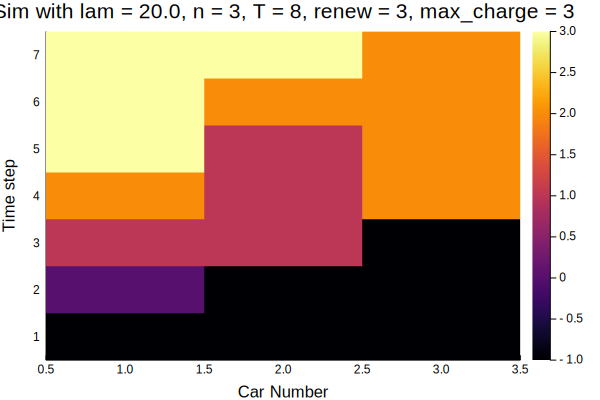

In [64]:
ev = simulate_evMDP(test_mdp,policy,seed=6)

heatmap(ev)
title!("Sim with lam = $(test_mdp.λ), n = $(test_mdp.n), T = $(test_mdp.T), renew = $(test_mdp.renew_levels), max_charge = $(test_mdp.charge_levels)")
yaxis!("Time step")
xaxis!("Car Number")
#savefig("ExampleCharge.png")